# A/B Test (Bootstrap method)


## Описание:

Компания недавно ввела новый тип ставок: «средние ставки», в качестве альтернативы существующему типу ставок: «максимальной ставки». Один из наших заказчиков решил протестировать эту новую функцию и хочет провести A/B-тестирование, 
<br>
чтобы понять приносит ли средняя ставка больше конверсии чем максимальная.

--------
[Ссылка на источник датасета](https://www.kaggle.com/datasets/ilkeryildiz/example-dataset-for-ab-test)

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [3]:
%matplotlib inline
plt.style.use('ggplot')

In [4]:
path = "/home/zachary/data_analysis_dir/data_analysis_env/AB_test/"
list_of_names = ['control_group.csv', 'test_group.csv']

In [5]:
control, test = (pd.read_csv(path + list_of_names[group], sep=';') for group in range(2))

---
### Определение функций

In [6]:
def bootstrap(control,
              test,
              boot_it: int = 1000,
              bootstrap_cl: float = 0.95,
              loc='mean'):
    
    """Calculate bootstrap distribution, p_value and quintiles
    Inputs:
    
    control,
    test,
    boot_it = default 1000 points
    bootstrap_cl = confidence level by default 0.95 ~ 95%
    loc = default "mean" but you can calculate "median"
    """
    
    shift_sample = list()
    boot_len = max([len(control), len(test)])
    statistic = np.mean
    if loc == 'median':
        statistic = np.median
    for smple in range(boot_it):
        
        c_sample = control.sample(boot_len,
                                  replace=True).values
        t_sample = test.sample(boot_len,
                               replace=True).values
        
        shift_sample.append(statistic(c_sample - t_sample))
        
    booted_sample = pd.DataFrame(shift_sample)
        
    cl_left = (1 - bootstrap_cl) / 2 
    cl_right = 1 - (1 - bootstrap_cl) / 2 
    cl = booted_sample.quantile([cl_left, cl_right])
    
    
    p1 = stats.norm.cdf(x=0,
                        loc=np.mean(booted_sample),
                        scale=np.std(booted_sample))
    p2 = stats.norm.cdf(x=0,
                        loc=-np.mean(booted_sample),
                        scale=np.std(booted_sample))
    p_value = min(p1, p2) * 2
     
    plt.figure(figsize=(14, 10))
    _, _, bars = plt.hist(booted_sample[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= cl.iloc[0][0] or abs(bar.get_x()) >= cl.iloc[1][0]:
            bar.set_facecolor('red')
            bar.set_edgecolor('k')
        else: 
            bar.set_facecolor('darkgreen')
            bar.set_edgecolor('k')
            
    
    plt.style.use('ggplot')
    plt.vlines(cl,ymin=0,ymax=20,linestyle='--')
    plt.vlines(np.mean(booted_sample), ymin=0,ymax=30,color='orange', linestyle='dashed', linewidth=1.5)
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
        
    plt.show()
    
    return {"booted_sample": booted_sample,
            "cl": cl,
            "p_value": p_value}

In [7]:
def plot(data_1, data_2, cl: bool = False): 
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 8)

    
    ax[0].hist(data_1, color="#e74c3c")
    ax[1].hist(data_2, color="#34496e")
    if cl == False:
        
        # Построим вертикальные линии средних  
        ax[0].axvline(np.mean(data_1), color='orange', linestyle='dashed', linewidth=1.5)
        ax[1].axvline(np.mean(data_2), color='orange', linestyle='dashed', linewidth=1.5)

    else:
        
        # Доверительные интервалы
        ci = 0.95
        
        ci_left = (1 - ci) / 2
        ci_right = 1 - (1 - ci) / 2
        control_mean_ci = pd.Series(data_1).quantile([ci_left, ci_right])
        test_mean_ci = pd.Series(data_2).quantile([ci_left, ci_right])
        
        ax[0].axvline(np.mean(data_1), color='orange', linestyle='dashed', linewidth=1.8)
        ax[1].axvline(np.mean(data_2), color='orange', linestyle='dashed', linewidth=1.8)

        ax[0].vlines(control_mean_ci, color='red', ymin=0, ymax=200, linestyle='--', linewidth=1.2)
        ax[1].vlines(test_mean_ci, color='red', ymin=0, ymax=200, linestyle='--', linewidth=1.2)
        
    bbox_props = dict( boxstyle="round", fc="w", ec="0.5")
        
    ax[0].annotate(f"Mean = {round(np.mean(data_1), 2)}", xy=(0.98, 0.95), 
                        xycoords='axes fraction', fontsize=12,
                    horizontalalignment='right', bbox=bbox_props)

    ax[1].annotate(f"Mean = {round(np.mean(data_2), 2)}", xy=(0.98, 0.95), 
                        xycoords='axes fraction', fontsize=12,
                    horizontalalignment='right', bbox=bbox_props)

---
### Предобработка

In [8]:
# Исправляем заголовки для большей: "usability"
test.columns, control.columns = control.columns.str.replace(' ', '_') \
                                       .str.replace('#', 'Number'), test \
                                       .columns.str.replace(' ', '_') \
                                       .str.replace('#', 'Number')

In [9]:
# Здесь необходимо оценить количество наблюдений
control.shape

(30, 10)

In [10]:
test.shape

(30, 10)

In [11]:
# Есть один пропуск в контроле, необходимо подумать чем мы будем заполнять
control[control.isna().any(axis=1)]

,Campaign_Name,Date,Spend_[USD],Number_of_Impressions,Reach,Number_of_Website_Clicks,Number_of_Searches,Number_of_View_Content,Number_of_Add_to_Cart,Number_of_Purchase
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Есть два пути:
- Заполнить NaN значения используя алгоритм K-ближайших соседей (Рекомендуется при малых n)
- Просто скипнуть тем самым увеличив вероятность получить ошибку первого рода

In [12]:
# Заполняем NaN значения средним используя алгоритм К-ближайших соседей
imputer = KNNImputer(weights='distance')
control.iloc[:,2:10] = pd.DataFrame(imputer.fit_transform(control.iloc[:,2:10]))

---
## Визуализация

In [13]:
# Посчитаем основные и побочные метрики, но использовать мы будем одну - Конверсию от покупок

In [14]:
control['CTR'], \
test['CTR'] = control['Number_of_Website_Clicks'] / control['Number_of_Impressions'] * 100, \
                              test['Number_of_Website_Clicks'] / test['Number_of_Impressions'] * 100

In [15]:
control['Conversion_of_purchase'], \
test['Conversion_of_purchase'] = control['Number_of_Purchase'] / control['Number_of_Add_to_Cart'] * 100, \
                                 test['Number_of_Purchase'] / test['Number_of_Add_to_Cart'] * 100

In [16]:
control['Сonversion_of_view'], \
test['Сonversion_of_view'] = control['Number_of_View_Content'] / control['Number_of_Searches'] * 100, \
                                 test['Number_of_View_Content'] / test['Number_of_Searches'] * 100

In [17]:
control['Spend_USD_per_purchase'], \
test['Spend_USD_per_purchase'] = control['Spend_[USD]'] / control['Number_of_Purchase'], \
                                 test['Spend_[USD]'] / test['Number_of_Purchase']

In [18]:
# Так как данных у нас мало, есть смысл построить qq plot или boxplot
# для оценки распредления я воспользуюсь ящиками с усами

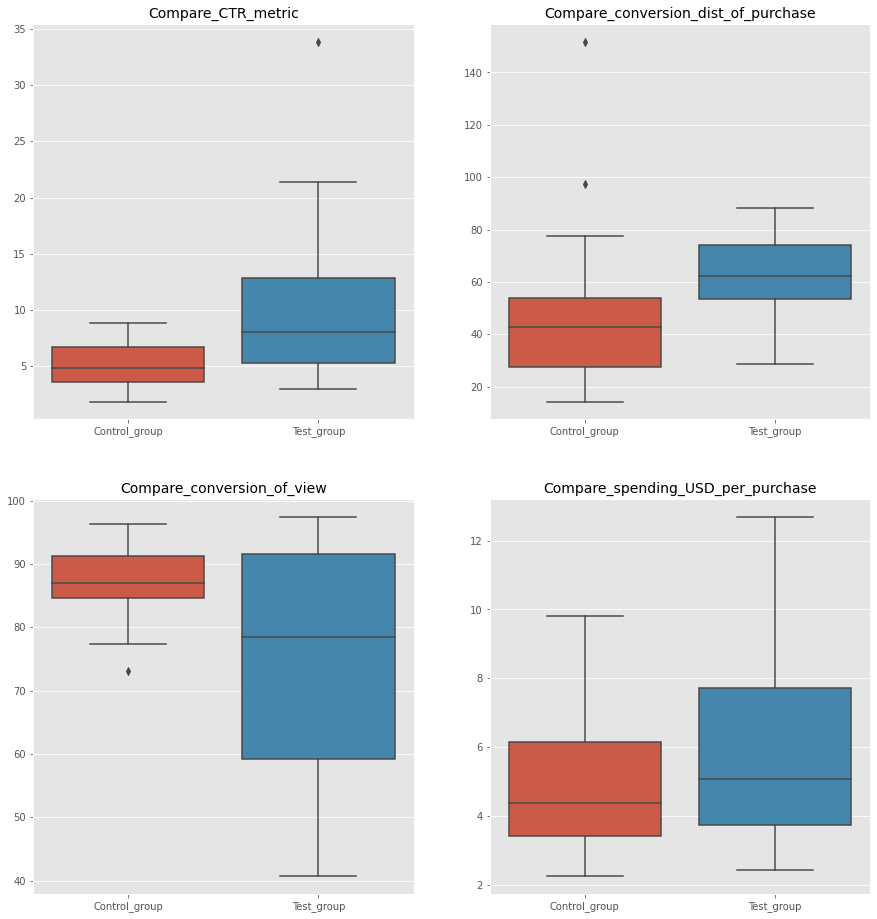

In [19]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15, 16)

barplot1 = sns.boxplot(data=[control['CTR'], test['CTR']], ax=ax[0, 0])
ax[0, 0].set_xticklabels(['Control_group', 'Test_group'])
ax[0, 0].set_title('Compare_CTR_metric', fontsize=14)

barplot2 = sns.boxplot(data=[control['Conversion_of_purchase'], test['Conversion_of_purchase']], ax=ax[0, 1])
ax[0, 1].set_xticklabels(['Control_group', 'Test_group'])
ax[0, 1].set_title('Compare_conversion_dist_of_purchase', fontsize=14)

barplot3 = sns.boxplot(data=[control['Сonversion_of_view'], test['Сonversion_of_view']], ax=ax[1, 0])
ax[1, 0].set_xticklabels(['Control_group', 'Test_group'])
ax[1, 0].set_title('Compare_conversion_of_view', fontsize=14)

barplot4 = sns.boxplot(data=[control['Spend_USD_per_purchase'], test['Spend_USD_per_purchase']], ax=ax[1, 1])
ax[1, 1].set_xticklabels(['Control_group', 'Test_group'])
ax[1, 1].set_title('Compare_spending_USD_per_purchase', fontsize=14)

plt.show()

#### Что мы видем на графиках выше? 

- CTR метрика у теста имеет значительный выброс в верхних значениях.
Однако больше 50% входят в распределение Контроля

- Наша главная метрика - Конверсия от покупок уже распределена не так хорошо,
после тестирования будет понятно так ли это.

- Конверсия по просмотрам сдала позиции также как и другие 2 метрики 

- Количество трат в USD за покупку имеет лучше распределение по 1 и 2 квартилю по сравнению с другими метриками 
практически идентичны Тест и Контроль

In [20]:
# Let's using bootstrap for nonparamters value 

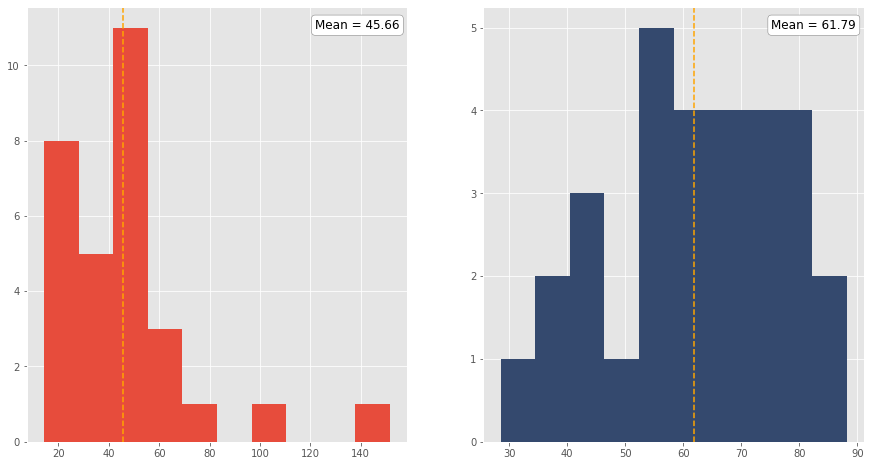

In [21]:
plot(control['Conversion_of_purchase'], test['Conversion_of_purchase'])

#### Невозможно понять каким является распределение из-за острой нехватки n-наблюдений

In [22]:
# Подготовим данные к тестам
control_target, test_target = control['Conversion_of_purchase'], control['Conversion_of_purchase'] 

In [23]:
# Смотрим средние Контрольной и средней Bootstrap
n = 1000
ci = 0.95

bootsrap_dist_c = []

for i in range(n): 
    sample = control_target.sample(control_target.shape[0], replace=True)
    bootsrap_dist_c.append(np.mean(sample))

In [24]:
print(f'Среднее Control vs Bootstrap Control: {round(np.mean(control_target), 2)}, {round(np.mean(bootsrap_dist_c), 2)}')

Среднее control: 45.66 compare with Среднее bootstrap control: 45.67


In [25]:
# Смотрим средние Теста и средней Bootstrap
n = 1000
ci = 0.95

bootsrap_dist_t = []

for i in range(n): 
    sample = test_target.sample(test_target.shape[0], replace=True)
    bootsrap_dist_t.append(np.mean(sample))

In [26]:
print(f'Среднее Test vs Bootstrap Test: {round(np.mean(test_target), 2)}, {round(np.mean(bootsrap_dist_t), 2)}')

Среднее control: 45.66 comapare with Среднее bootstrap control: 45.41


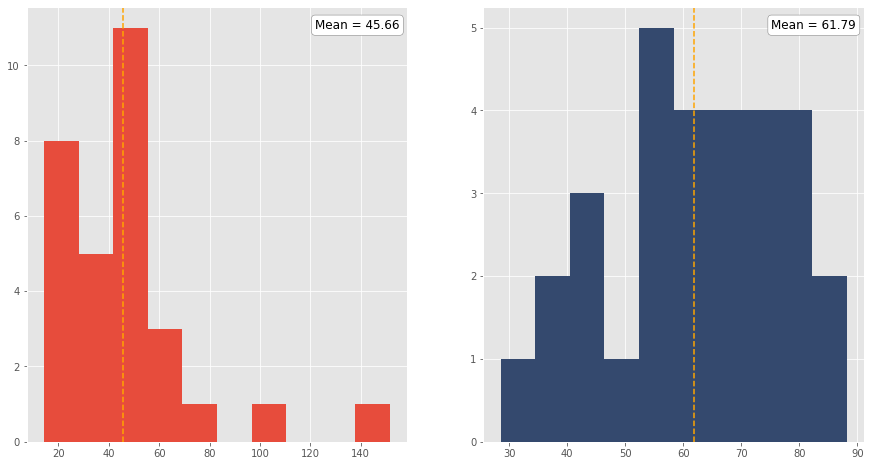

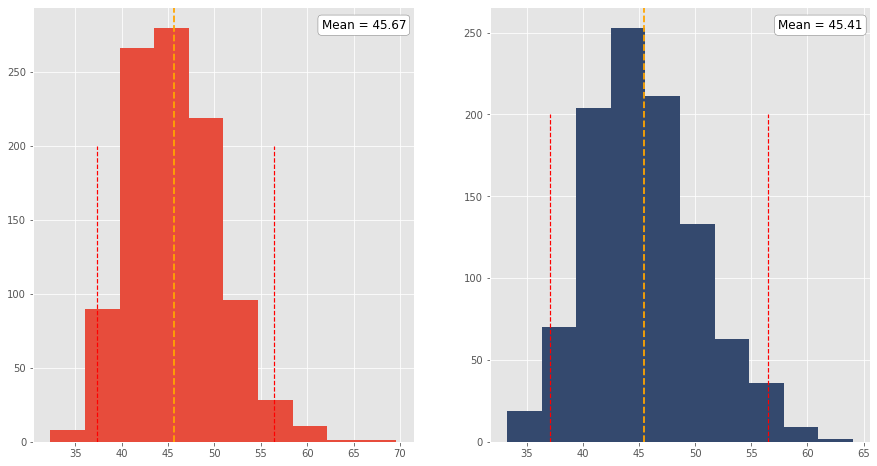

In [27]:
# Построим bootstrap распределения с доверительными интервалами, сравним наблюдения до и после
plot(control['Conversion_of_purchase'], test['Conversion_of_purchase'])
plot(bootsrap_dist_c, bootsrap_dist_t, cl=True)

---
## Bootstrap 

#### Проверем гипотезу Bootstrap стат. метода о равенстве средних

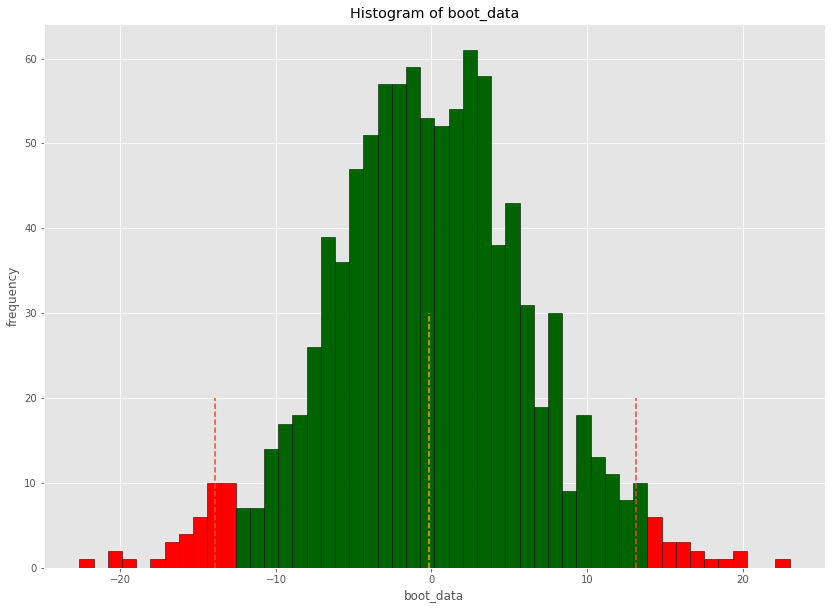

In [32]:
booted_mean_sample = bootstrap(control=control_target, boot_it=1000, bootstrap_cl=0.95, test=test_target, loc='mean')

In [33]:
booted_mean_sample['p_value']

array([0.9794568])

#### Не обнаружены статистически значимые различия, мы не можем отвергнуть нулевую гипотезу
- Нулевое значение по оси абсцисс находится в пределах ДИ, это хорошо
- p-value высокий, однако стоит помнить, что несмотря на 1000 bootstrap наблюдений, мы все еще по факту работаем с 30-ю наблюдениями в каждой из выборок.
- Для бизнеса это значит, что нет никаких оснований считать тестирование нового алгоритма Test выборки результативным 

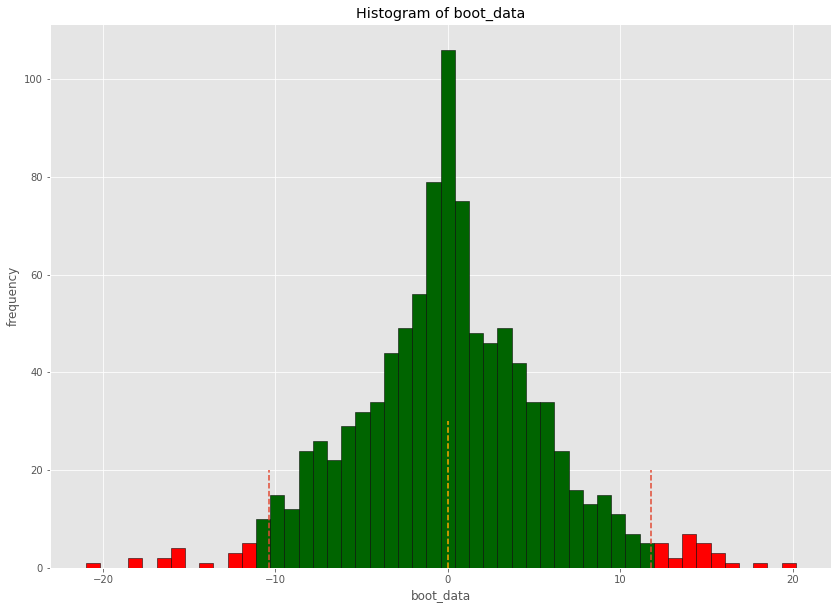

In [34]:
booted_median_sample = bootstrap(control=control_target, bootstrap_cl=0.95, test=test_target, loc='median')

In [31]:
booted_median_sample['p_value']

array([0.98185044])

In [ ]:
# Абсолютно идентичный вариант и с медианой.